In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
url="https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2" \
    "Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


In [4]:
countries = {"Russia", "Italy", "Japan", "Spain", "Germany", "Korea, South", "Brazil"}

In [5]:
df[df["Country/Region"].isin(countries)]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
28,NaN,Brazil,-14.235,-51.9253,0,0,0,0,0,0,...,321,372,621,793,1021,1546,1924,2247,2554,2985
120,NaN,Germany,51.000,9.0000,0,0,0,0,0,1,...,9257,12327,15320,19848,22213,24873,29056,32986,37323,43938
137,NaN,Italy,43.000,12.0000,0,0,0,0,0,0,...,31506,35713,41035,47021,53578,59138,63927,69176,74386,80589
139,NaN,Japan,36.000,138.0000,2,2,2,2,4,4,...,878,889,924,963,1007,1101,1128,1193,1307,1387
143,NaN,"Korea, South",36.000,128.0000,1,1,2,2,3,4,...,8320,8413,8565,8652,8799,8961,8961,9037,9137,9241
187,NaN,Russia,60.000,90.0000,0,0,0,0,0,0,...,114,147,199,253,306,367,438,495,658,840
201,NaN,Spain,40.000,-4.0000,0,0,0,0,0,0,...,11748,13910,17963,20410,25374,28768,35136,39885,49515,57786


In [6]:
confirmed = dict()
for country in countries:
    cdf = df[(df["Country/Region"]==country) & (df["Province/State"].isnull())][df.columns[4:-1]].T
    if len(cdf.columns) > 0:
        confirmed[country] = np.array(cdf[cdf.columns[0]])

In [7]:
cdf = df[(df["Province/State"]=="Hubei")][df.columns[4:-1]].T
confirmed["Hubei"] = np.array(cdf[cdf.columns[0]])

In [8]:
import matplotlib.pyplot as plt

In [9]:
def exp_smoothing(lst, alpha=0.1):
    tmp_ = lst[0]
    result = [tmp_]
    for x in lst[1:]:
        tmp_ =  x * (1 - alpha) + alpha * tmp_
        result.append(tmp_)
    return result

In [10]:
def division_smoothed(lst):
    result = []
    for prev, cur in zip(lst[:-1], lst[1:]):
        if prev < 1.0:
            result.append(1.0)
        else:
            result.append(cur / prev)
    return result

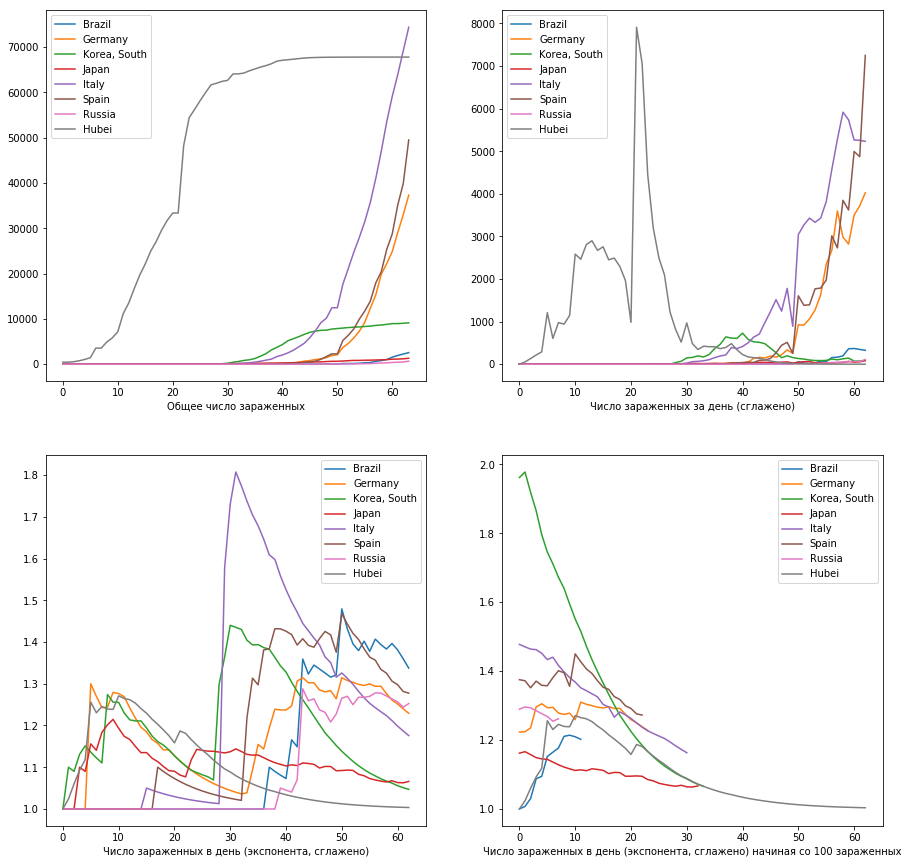

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].set_xlabel("Общее число зараженных")
for country, cases in confirmed.items():
    ax[0, 0].plot(range(0, len(cases)), cases, label=country)
ax[0, 0].legend()

ax[0, 1].set_xlabel("Число зараженных за день (cглажено)")
for country, cases in confirmed.items():
    ax[0, 1].plot(range(0, len(cases) - 1), exp_smoothing(cases[1:] - cases[:-1], alpha=0.5), label=country)
ax[0, 1].legend()

ax[1, 0].set_xlabel("Число зараженных в день (экспонента, сглажено)")
for country, cases in confirmed.items():
    ax[1, 0].plot(range(0, len(cases) - 1), exp_smoothing(division_smoothed(cases), alpha=0.9), label=country)
ax[1, 0].legend()

ax[1, 1].set_xlabel("Число зараженных в день (экспонента, сглажено) начиная со 100 зараженных")
for country, cases in confirmed.items():
    cases = cases[cases.searchsorted(100):]
    ax[1, 1].plot(range(0, len(cases) - 1), exp_smoothing(cases[1:] / (cases[:-1]), alpha=0.9), label=country)
ax[1, 1].legend()

fig.savefig("covid19.png")
plt.show()